In [2]:
%matplotlib inline
import numpy as np
import random
import math
import cv2
import matplotlib.pyplot as plt # matplotlibの描画系
import quaternion

In [3]:
#三次元回転行列生成に関する関数
    # 物体座標系の 1->2->3 軸で回転させる
def generateRotationMatrix(r):
    px = r[0]
    py = r[1]
    pz = r[2]
    
    Rx = np.array([[1, 0, 0],
            [0, np.cos(px), np.sin(px)],
            [0, -np.sin(px), np.cos(px)]])
    Ry = np.array([[np.cos(py), 0, -np.sin(py)],
            [0, 1, 0],
            [np.sin(py), 0, np.cos(py)]])
    Rz = np.array([[np.cos(pz), np.sin(pz), 0],
            [-np.sin(pz), np.cos(pz), 0],
            [0, 0, 1]])
    R = Rz.dot(Ry).dot(Rx)
    return R

def generateTransMatrix(t, r):
    R = generateRotationMatrix(r)
    transMatrix = np.eye(4,4)
    for y in range(0,3):
        for x in range(0,3):
            transMatrix[y, x] = R[y, x]
        transMatrix[y, 3] = t[y]
    return transMatrix

[[ 0.97394279 -0.10441624 -0.20132732  0.02319565]
 [ 0.10527311  0.99442226 -0.0064763  -0.01639449]
 [ 0.2008806  -0.01488681  0.97950261 -0.02705196]
 [ 0.          0.          0.          1.        ]]


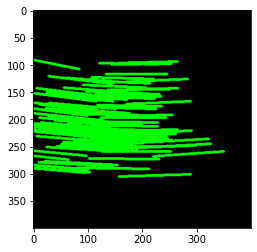

In [52]:
#観測データ生成
#位置姿勢の初期値（ランダム）
t = np.random.randn(3)*0.03
p = np.random.randn(3) * np.pi / 16
GM = generateTransMatrix(t, p)
print(GM)

#三次元点群
depth = 10
num_points = 100
PP = []
PG = []
for i in range(num_points):
    pt = np.random.randn(2)
    pt = [pt[0], pt[1], depth]    
    PP.append(pt)
    PG.append(pt)
PP = np.array(PP).transpose()
PG = np.array(PG).transpose()

#projection(to normal coord)
R = GM[0:3,0:3]
T = GM[0:3,3:4]
CPP = R @ PP + T
cpg = CPP[0:2,:] / CPP[2,:] 
cpp = CPP[0:2,:] / CPP[2,:] + np.random.randn(2,100) * 0.1 #with noise

pg = PG[0:2,:] / PG[2,:]

#debug flow
im_size = 400
f = 600
c = im_size / 2
image = np.zeros((im_size, im_size, 3), np.uint8)
for i in range(pg.shape[1]):
    p0 = cpg[:,i] * f + c
    p1 = pg[:,i] * f + c
    cv2.line(image,
         pt1=(int(p0[0]), int(p0[1])),
         pt2=(int(p1[0]), int(p1[1])),
         color=(0, 255, 0),
         thickness=3,
         lineType=cv2.LINE_4,
         shift=0)
    
plt.imshow(image)



In [53]:

prior = np.zeros((6,1))
prior[0:3,0:1] = GM[0:3,3:4]
#pR = quaternion.from_rotation_matrix(GM[0:3,0:3])
#prior[3:6,0] = quaternion.as_rotation_vector(pR)
prior[3:6,0:1] = cv2.Rodrigues(GM[0:3,0:3])[0]
print(prior)

[[ 0.02319565]
 [-0.01639449]
 [-0.02705196]
 [-0.00424218]
 [-0.20286972]
 [ 0.10576525]]


[[ 1.01000000e+02  0.00000000e+00  1.37431524e-02  1.02406566e-02
   1.01135508e+01 -1.26293182e-01]
 [ 0.00000000e+00  1.01000000e+02 -1.26293182e-02 -1.00649633e+01
  -1.02406566e-02 -1.37431524e-01]
 [ 1.37431524e-02 -1.26293182e-02  1.00017851e+02  1.30683915e-01
   1.43767126e-01  2.30908531e-20]
 [ 1.02406566e-02 -1.00649633e+01  1.30683915e-01  2.01318569e+02
   2.09103600e-01  1.37431524e+00]
 [ 1.01135508e+01 -1.02406566e-02  1.43767126e-01  2.09103600e-01
   2.02316828e+02 -1.26293182e+00]
 [-1.26293182e-01 -1.37431524e-01  2.30908531e-20  1.37431524e+00
  -1.26293182e+00  1.01785140e+02]]
[[  0.25890354]
 [ -1.95063093]
 [ -2.75943547]
 [  2.67955953]
 [-41.14803239]
 [ 10.83660605]]


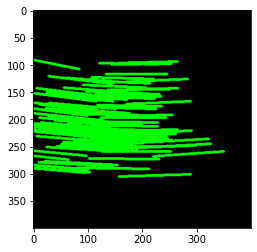

[[ 1.01056215e+02  0.00000000e+00  2.39817414e-01 -2.65689218e-02
   1.09229707e+01  1.38484901e-01]
 [ 0.00000000e+00  1.01056215e+02  1.42942836e-02 -1.03434718e+01
   2.65689218e-02 -2.30744407e+00]
 [ 2.39817414e-01  1.42942836e-02  1.00074940e+02 -1.47701335e-01
   2.52966564e+00  4.13120977e-19]
 [-2.65689218e-02 -1.03434718e+01 -1.47701335e-01  2.01391383e+02
  -5.31914424e-01  2.22106115e+01]
 [ 1.09229707e+01  2.65689218e-02  2.52966564e+00 -5.31914424e-01
   2.13117464e+02  1.34159975e+00]
 [ 1.38484901e-01 -2.30744407e+00  4.13120977e-19  2.22106115e+01
   1.34159975e+00  1.06862702e+02]]
[[ 0.02699691]
 [ 0.11150933]
 [ 0.00733768]
 [-1.08362172]
 [ 0.1467393 ]
 [-0.11629622]]


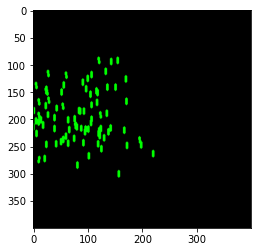

[[ 1.01055782e+02  0.00000000e+00  2.38926593e-01 -1.37737189e-02
   1.09172610e+01  8.20548451e-02]
 [ 0.00000000e+00  1.01055782e+02  8.45548675e-03 -1.03401040e+01
   1.37737189e-02 -2.29933178e+00]
 [ 2.38926593e-01  8.45548675e-03  1.00074412e+02 -8.65189709e-02
   2.51972996e+00 -8.73808691e-19]
 [-1.37737189e-02 -1.03401040e+01 -8.65189709e-02  2.01365738e+02
  -2.73773808e-01  2.21368868e+01]
 [ 1.09172610e+01  1.37737189e-02  2.51972996e+00 -2.73773808e-01
   2.13044054e+02  7.95993500e-01]
 [ 8.20548451e-02 -2.29933178e+00 -8.73808691e-19  2.21368868e+01
   7.95993500e-01  1.06817205e+02]]
[[ 0.00013318]
 [-0.00013859]
 [ 0.00063948]
 [ 0.00023065]
 [ 0.00157703]
 [-0.00070602]]


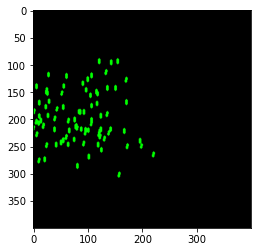

[[ 1.01055777e+02  0.00000000e+00  2.38916868e-01 -1.37736313e-02
   1.09171978e+01  8.20589886e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45589124e-03 -1.03400802e+01
   1.37736313e-02 -2.29924370e+00]
 [ 2.38916868e-01  8.45589124e-03  1.00074407e+02 -8.65230543e-02
   2.51962427e+00 -1.32950549e-18]
 [-1.37736313e-02 -1.03400802e+01 -8.65230543e-02  2.01365732e+02
  -2.73772188e-01  2.21360910e+01]
 [ 1.09171978e+01  1.37736313e-02  2.51962427e+00 -2.73772188e-01
   2.13043257e+02  7.96035855e-01]
 [ 8.20589886e-02 -2.29924370e+00 -1.32950549e-18  2.21360910e+01
   7.96035855e-01  1.06816840e+02]]
[[-2.63892328e-07]
 [ 3.38323657e-08]
 [-2.30958212e-07]
 [-5.34391854e-07]
 [ 2.88135204e-06]
 [-1.76316669e-06]]


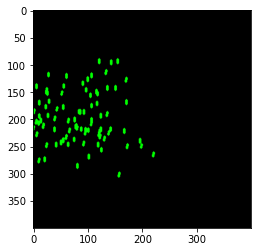

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589415e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00  1.40221637e-18]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589415e-02 -2.29924354e+00  1.40221637e-18  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[-4.60516188e-10]
 [-2.93186628e-10]
 [ 6.63084865e-12]
 [-1.12805543e-10]
 [ 6.70380015e-09]
 [-2.39277567e-09]]


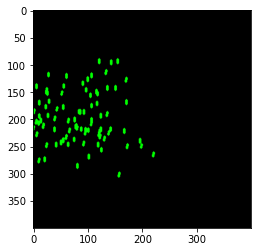

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589414e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00 -1.60491301e-18]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589414e-02 -2.29924354e+00 -1.60491301e-18  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[-8.68371347e-13]
 [-1.42205692e-13]
 [-3.14533122e-13]
 [-3.19078097e-12]
 [ 1.04705342e-11]
 [-8.98404268e-12]]


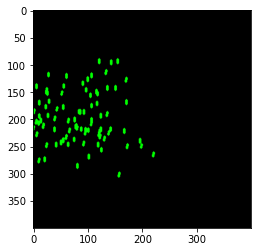

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589414e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00  7.90129147e-19]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589414e-02 -2.29924354e+00  7.90129147e-19  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[-2.15799600e-15]
 [-1.56819002e-15]
 [ 1.07552856e-16]
 [-2.05835349e-13]
 [ 1.93595140e-14]
 [ 3.92741395e-15]]


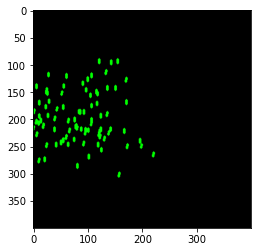

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589414e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00  4.31240869e-19]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589414e-02 -2.29924354e+00  4.31240869e-19  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[ 9.64506253e-16]
 [ 1.02834408e-14]
 [ 4.54497551e-16]
 [-2.06279438e-13]
 [ 1.94705363e-14]
 [ 3.69843045e-15]]


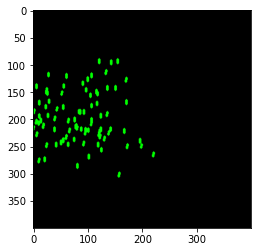

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589414e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00  4.31240869e-19]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589414e-02 -2.29924354e+00  4.31240869e-19  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[ 9.64506253e-16]
 [ 1.02834408e-14]
 [ 4.54497551e-16]
 [-2.06279438e-13]
 [ 1.94705363e-14]
 [ 3.69843045e-15]]


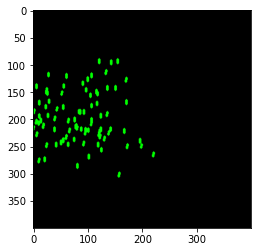

[[ 1.01055777e+02  0.00000000e+00  2.38916851e-01 -1.37736186e-02
   1.09171977e+01  8.20589414e-02]
 [ 0.00000000e+00  1.01055777e+02  8.45588633e-03 -1.03400802e+01
   1.37736186e-02 -2.29924354e+00]
 [ 2.38916851e-01  8.45588633e-03  1.00074407e+02 -8.65230024e-02
   2.51962409e+00  4.31240869e-19]
 [-1.37736186e-02 -1.03400802e+01 -8.65230024e-02  2.01365732e+02
  -2.73771932e-01  2.21360896e+01]
 [ 1.09171977e+01  1.37736186e-02  2.51962409e+00 -2.73771932e-01
   2.13043255e+02  7.96035402e-01]
 [ 8.20589414e-02 -2.29924354e+00  4.31240869e-19  2.21360896e+01
   7.96035402e-01  1.06816840e+02]]
[[ 9.64506253e-16]
 [ 1.02834408e-14]
 [ 4.54497551e-16]
 [-2.06279438e-13]
 [ 1.94705363e-14]
 [ 3.69843045e-15]]


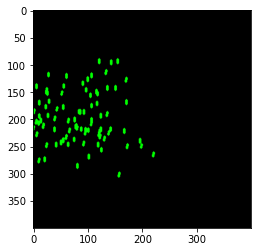

estimation
[[ 0.97407824 -0.10410598 -0.2008321   0.02330586]
 [ 0.10276465  0.99455833 -0.01712203 -0.01745262]
 [ 0.20152174 -0.00396025  0.97947604 -0.02726311]
 [ 0.          0.          0.          1.        ]]
ground truth
[[ 0.97394279 -0.10441624 -0.20132732  0.02319565]
 [ 0.10527311  0.99442226 -0.0064763  -0.01639449]
 [ 0.2008806  -0.01488681  0.97950261 -0.02705196]
 [ 0.          0.          0.          1.        ]]


In [69]:
#位置姿勢推定
R = np.eye(3)
T = np.zeros((3,1))

debug_show = True
use_prior = True
priorInfo = np.eye(6) * 1e2

for i in range(10):
    image = np.zeros((im_size, im_size, 3),np.uint8)
    JtJ = np.zeros((6,6))
    JtE = np.zeros((6,1))
    E = np.zeros((2,1))

    eR = GM[0:3,0:3] @ R.transpose()
    eT = GM[0:3,3:4] - T
    prior = np.zeros((6,1))
    prior[0:3,0:1] = eT
    prior[3:6,0:1] = cv2.Rodrigues(eR)[0]
    
    for j in range(PP.shape[1]):
        projectPP = R @ PP[:,j:j+1] + T
        Xc = projectPP[0,0]
        Yc = projectPP[1,0]
        Zc = projectPP[2,0]
        xc = Xc / Zc
        yc = Yc / Zc
        A00 = 1 / Zc
        A02 = - xc / Zc
        A03 = - xc * yc
        A04 = 1 + xc * xc
        A05 = - yc
        A11 = 1 / Zc
        A12 = -yc / Zc
        A13 = -1 - yc * yc
        A14 = xc * yc
        A15 = xc
        A_ = np.array(
            [[A00, 0, A02, A03, A04, A05],
             [0, A11, A12, A13, A14, A15]]
        )
        E_ = cpp[:,j:j+1] - np.array([[xc],[yc]]) 
        JtJ += A_.transpose() @ A_
        JtE += A_.transpose() @ E_
        E += E_

        if(debug_show):
            p0 = np.array([xc,yc]) * f + c 
            p1 = cpg[:,j] * f + c
            cv2.line(image,
            pt1=(int(p0[0]), int(p0[1])),
            pt2=(int(p1[0]), int(p1[1])),
            color=(0, 255, 0),
            thickness=3,
            lineType=cv2.LINE_4,
            shift=0)

    if(use_prior):
        JtJ += priorInfo
        JtE += priorInfo @  prior   
    print(JtJ)
    print(JtE)
    ext = np.linalg.inv(JtJ) @ JtE
    T += ext[0:3,0:1]
    omega = ext[3:6,0]
    quat = quaternion.from_rotation_vector(omega)
    dR = quaternion.as_rotation_matrix(quat)

    R = dR @ R
    if(debug_show):
        plt.imshow(image)
        plt.show()

estM = np.eye(4)
estM[0:3,0:3] = R
estM[0:3,3:4] = T

print("estimation")
print(estM)
print("ground truth")
print(GM)